# NOAA 自然重建数据的处理

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import os
from hydra import compose, initialize
from mksci_font import config_font

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

config_font({"font.size": 9})

## 筛选数据

In [3]:
from past1000.data import load_nat_data

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 19 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 10 files matching the pattern.
/Users/songshgeo/Documents/VSCode/past1000/past1000/data.py:96: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=sep, skiprows=lino_1st - 1, index_col=0)


,yang2019d,yi2010,yang2016,tan2011,xu2023c,liu2020,yi2012,li2015b,chen2020f,li2019a
year,,,,,,,,,,
2009,-0.809462,NaN,-0.568723,NaN,-1.466621,-0.314233,NaN,NaN,-0.346202,2.343614
2010,0.515620,NaN,0.307108,NaN,1.170888,-0.302521,NaN,NaN,-0.580140,2.828464
2011,-1.255668,NaN,NaN,NaN,1.248765,-0.760710,NaN,NaN,-0.752154,NaN
2012,NaN,NaN,NaN,NaN,-1.204711,0.169405,NaN,NaN,-2.389725,NaN
2013,NaN,NaN,NaN,NaN,0.140132,0.748762,NaN,NaN,NaN,NaN


<Axes: xlabel='year'>

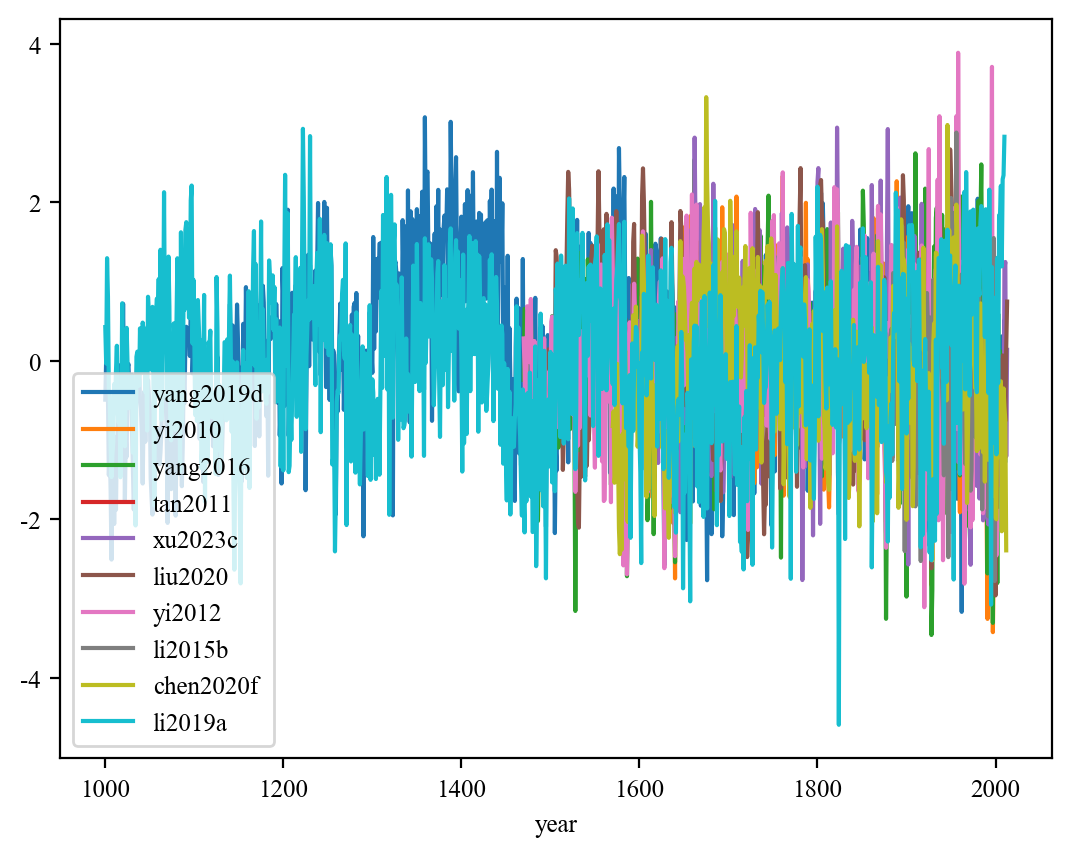

In [4]:
datasets.plot()

## 空间代表性

In [5]:
import rioxarray as rxr

data = rxr.open_rasterio(cfg.ds.instrumental.output) / 10
data.rio.crs

(117, 158, 256)

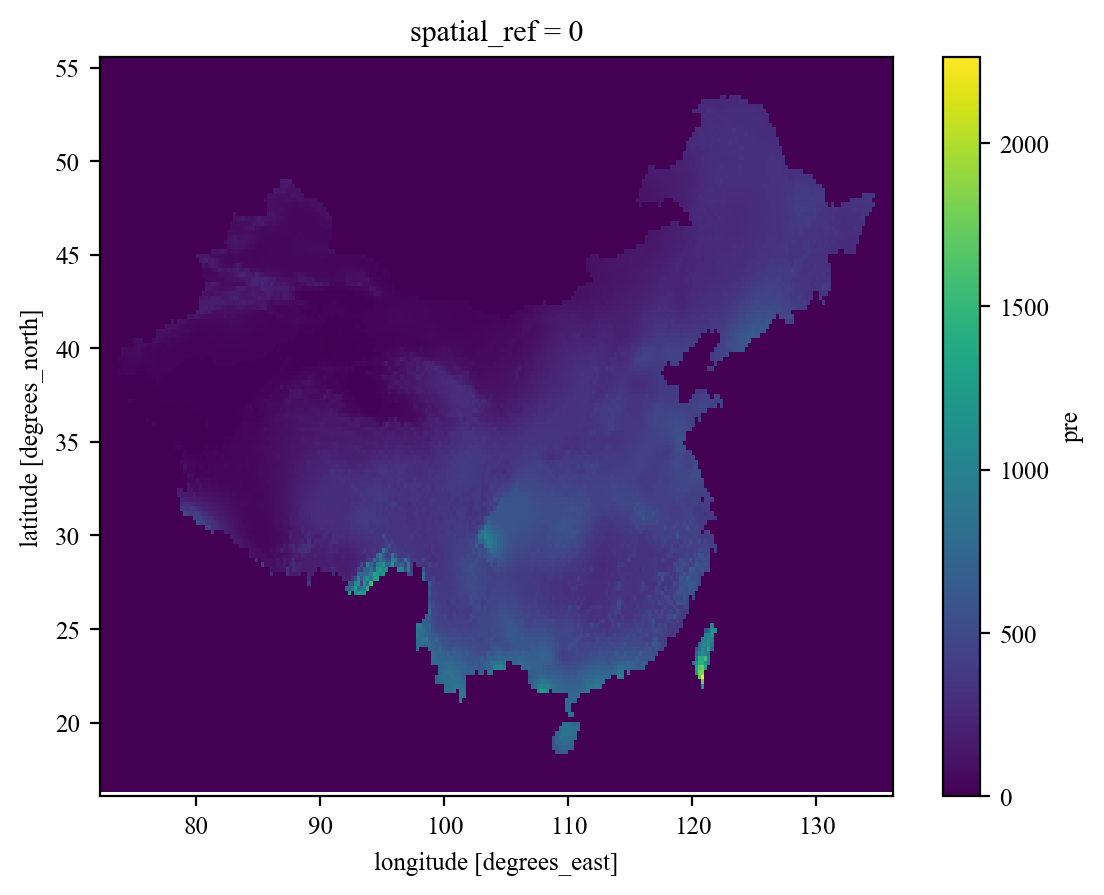

In [6]:
import xarray as xr
from rioxarray import rioxarray

summer_precip = xr.open_dataset(cfg.ds.instrumental.output)["pre"] / 10

summer_precip = summer_precip.rio.write_crs("EPSG:4326", inplace=True)
summer_precip = summer_precip.rio.set_spatial_dims(
    x_dim="lon",
    y_dim="lat",
    inplace=True,
)
summer_precip = summer_precip.rio.reproject(
    dst_crs="EPSG:4326",
    resolution=0.25,
)
summer_precip.shape
summer_precip.mean(dim="year").plot()

In [7]:
summer_precip_z = (summer_precip - summer_precip.mean(dim="year")) / summer_precip.std(
    dim="year"
)

In [8]:
from matplotlib import pyplot as plt
from matplotkit import with_axes
from past1000.utils.calc import calc_corr
import geopandas as gpd
import seaborn as sns

sns.set_theme(style="white")


@with_axes
def plot_corr_map(
    corr: xr.DataArray,
    p_value: xr.DataArray,
    threshold: float = 0.05,
    ax: plt.Axes | None = None,
    mask: bool = True,
    **kwargs,
) -> plt.Axes:
    """绘制相关性地图

    Args:
        corr (xr.DataArray): 相关性
        p_value (xr.DataArray): p值
        threshold (float, optional): 显著性阈值. Defaults to 0.05.
        ax (plt.Axes | None, optional): 坐标轴. Defaults to None.

    Returns:
        plt.Axes: 坐标轴
    """
    if ax is None:
        ax = plt.gca()
    corr_map = corr
    # 创建显著性掩码
    significant_mask = p_value < threshold
    p_value.plot.contour(
        ax=ax,
        levels=[0.01],
        colors=["black"],
        linewidths=0.8,
        linestyles=["--"],
        alpha=0.8,
    )
    p_value.plot.contour(
        ax=ax,
        levels=[0.05],
        colors=["gray"],
        linewidths=0.8,
        linestyles=["--"],
        alpha=0.8,
    )
    p_value.plot.contour(
        ax=ax,
        levels=[0.1],
        colors=["lightgray"],
        linewidths=1.5,
        linestyles=["--"],
        alpha=0.8,
    )

    if mask:
        corr_map = corr_map.where(significant_mask)
    corr_map.plot(
        ax=ax,
        cmap="RdBu_r",
        vmin=-0.5,
        vmax=0.5,
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.8, "aspect": 20},
    )
    zorder = -1
    for name, shp in cfg.ds.base_maps.items():
        gpd.read_file(shp).to_crs(summer_precip.rio.crs).plot(
            ax=ax,
            color="gray",
            edgecolor="black",
            linewidth=0.5,
            alpha=0.4,
            label=name,
            zorder=zorder,
        )
        zorder -= 1
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5, color="gray")
    return ax

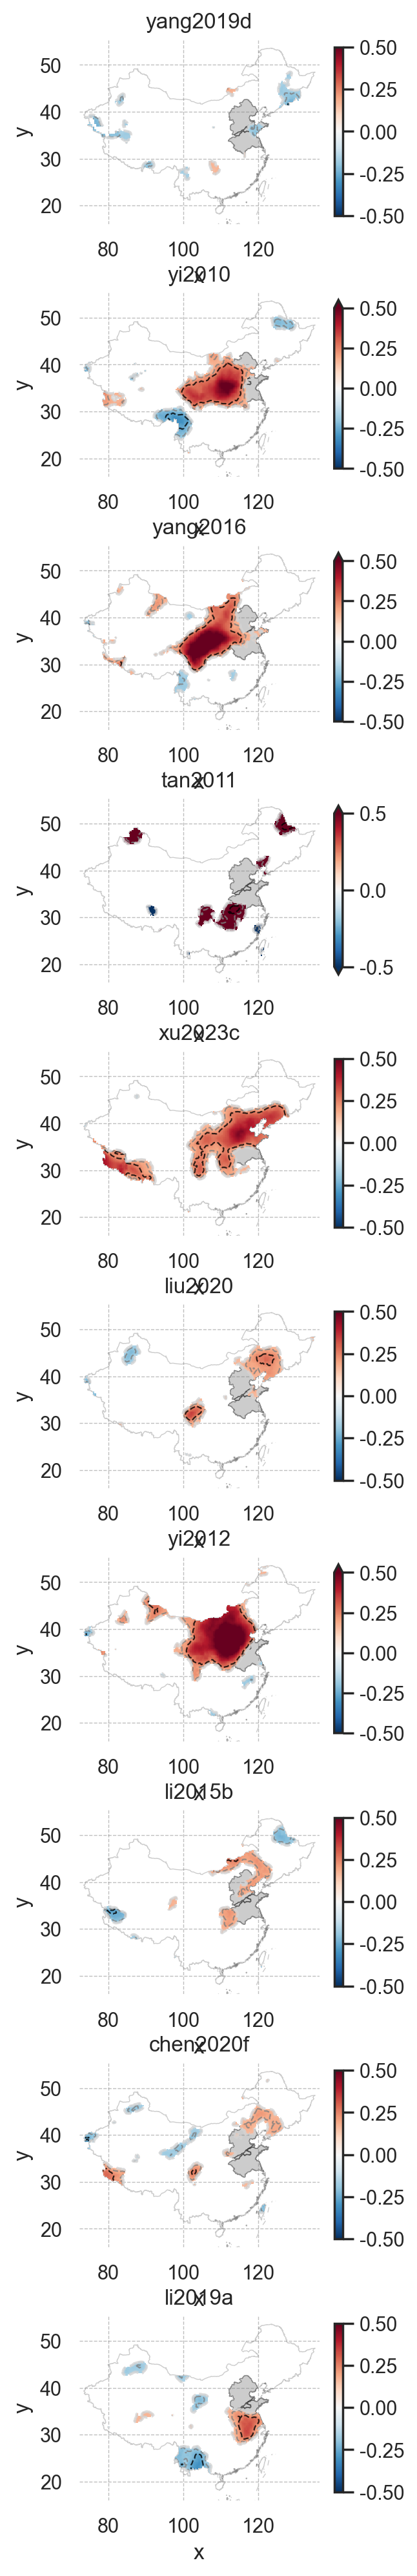

In [9]:
fig, axs = plt.subplots(
    ncols=1, nrows=len(datasets.columns), figsize=(3, len(datasets.columns) * 2.5)
)

for col, ax in zip(datasets.columns, axs):
    series = datasets[col].to_xarray()
    common_years = np.intersect1d(series.year.values, summer_precip_z.year.values)
    series = datasets[col].to_xarray()
    corr = xr.apply_ufunc(
        calc_corr,
        summer_precip_z.sel(year=common_years),
        series.sel(year=common_years),
        input_core_dims=[["year"], ["year"]],
        output_core_dims=[[], [], []],
        vectorize=True,
        output_dtypes=[float, float, int],
    )
    ax = plot_corr_map(corr[0], corr[1], threshold=0.1, ax=ax)
    ax.set_title(col)

plt.show();

## 分布测定

最佳分布：Student-t（t）表现最佳：

- 最低sumsquare_error（1.003480），表明直方图拟合最好。
- 较低的AIC（495.670695）和BIC（507.652580），优于lognorm和gamma。
- 最低ks_statistic（0.040494）和最高ks_pvalue（0.5134515），CDF拟合极佳。

次佳分布：lognorm：
- sumsquare_error（1.010543）、AIC（500.570491）、BIC（512.552375）略逊于t。
- ks_statistic（0.040599）和ks_pvalue（0.5101007）与t接近，拟合良好。

In [11]:
from past1000.data import check_distribution
from matplotlib import pyplot as plt


check_distribution(datasets)

2025-09-05 14:35:35.958 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3.262081)
2025-09-05 14:35:35.965 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.586181)
2025-09-05 14:35:35.990 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.238871)
2025-09-05 14:35:35.992 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=8.536277)
2025-09-05 14:35:36.000 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.23743)
2025-09-05 14:35:36.019 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted exponpow distribution with error=0.329223)
2025-09-05 14:35:36.051 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.241199)
2025-09-05 14:35:36.090 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted power

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue,best_dist
yang2019d,0.23743,512.520476,527.279528,inf,0.018852,0.857804,t
yi2010,1.00348,495.670695,507.65258,inf,0.040494,0.513451,t
yang2016,0.461476,512.808013,525.688271,inf,0.030158,0.697089,t
tan2011,6.759237,352.906872,357.950449,inf,0.057617,0.902688,norm
xu2023c,0.651503,460.106665,468.215544,inf,0.021442,0.987321,norm
liu2020,0.523874,467.969287,480.736537,inf,0.019359,0.98775,chi2
yi2012,0.492981,584.286043,597.121607,inf,0.026258,0.846268,t
li2015b,2.819712,460.004579,468.652985,inf,0.086142,0.265646,t
chen2020f,0.747401,490.709554,502.990263,inf,0.036155,0.595748,t
li2019a,0.185944,679.647617,694.403703,inf,0.021538,0.727844,t


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


array([[<Axes: title={'center': 'true_drought'}>,
        <Axes: title={'center': 'true_drought'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

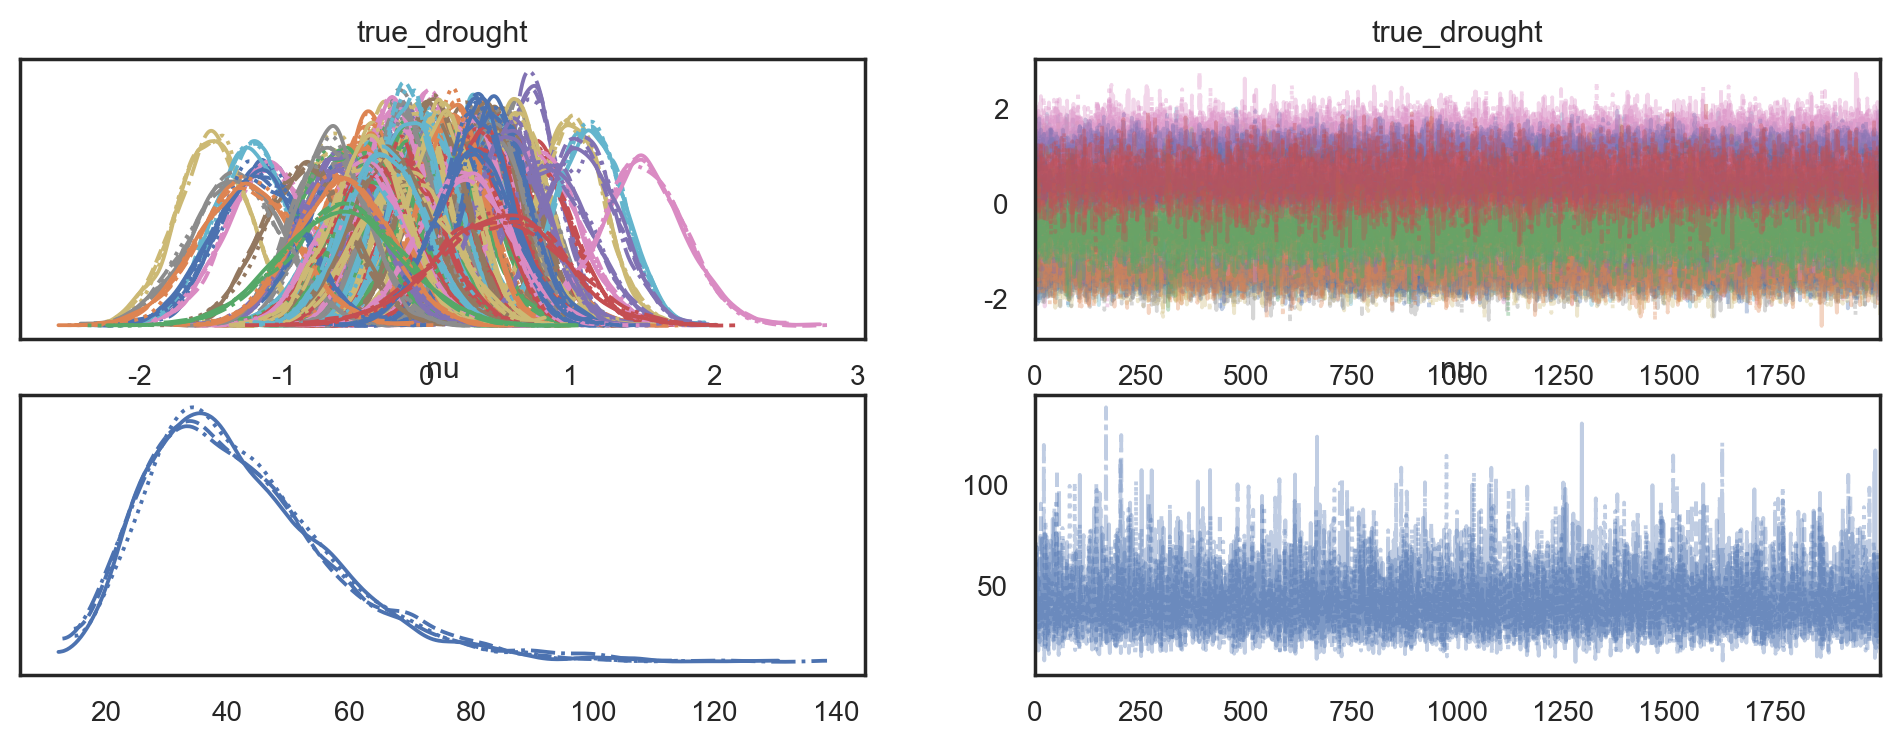

In [12]:
from past1000.mc import combine_reconstructions
import arviz as az
from past1000.constants import END

combined, trace = combine_reconstructions(
    datasets.loc[END:],
    uncertainties.loc[END:],
    standardize=True,
)

az.plot_trace(trace, var_names=["true_drought", "nu"])

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_56679/3206318887.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left')


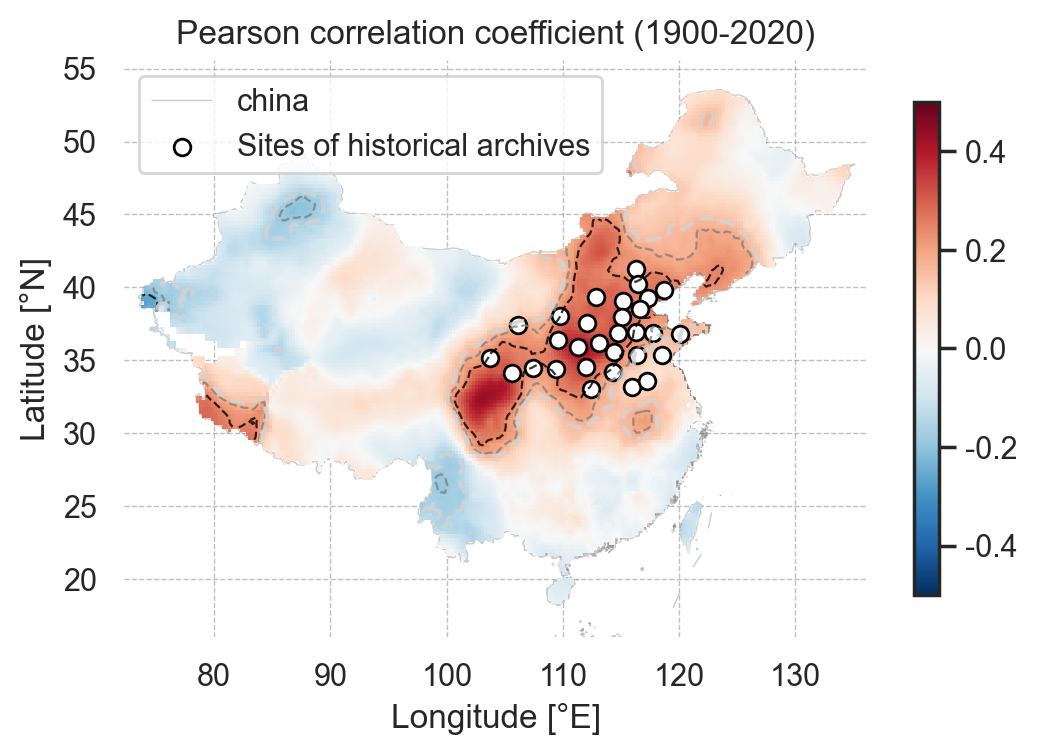

In [13]:
gdf = gpd.read_file(cfg.ds.atlas.shp)
outline = gpd.read_file(cfg.how.shp)
region = gdf[gdf["region"] == "华北地区"]

series = combined["mean"].to_xarray()
corr = xr.apply_ufunc(
    calc_corr,
    summer_precip_z.sel(year=common_years),
    series.sel(year=common_years),
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[[], [], []],
    vectorize=True,
    output_dtypes=[float, float, int],
)
ax = plot_corr_map(corr[0], corr[1], threshold=0.1, mask=False)
region.plot(
    ax=ax, color="white", edgecolor="black", label="Sites of historical archives"
)
ax.set_title("Pearson correlation coefficient (1900-2020)")
ax.set_xlabel("Longitude [°E]")
ax.set_ylabel("Latitude [°N]")
ax.legend(loc="upper left")
plt.show();

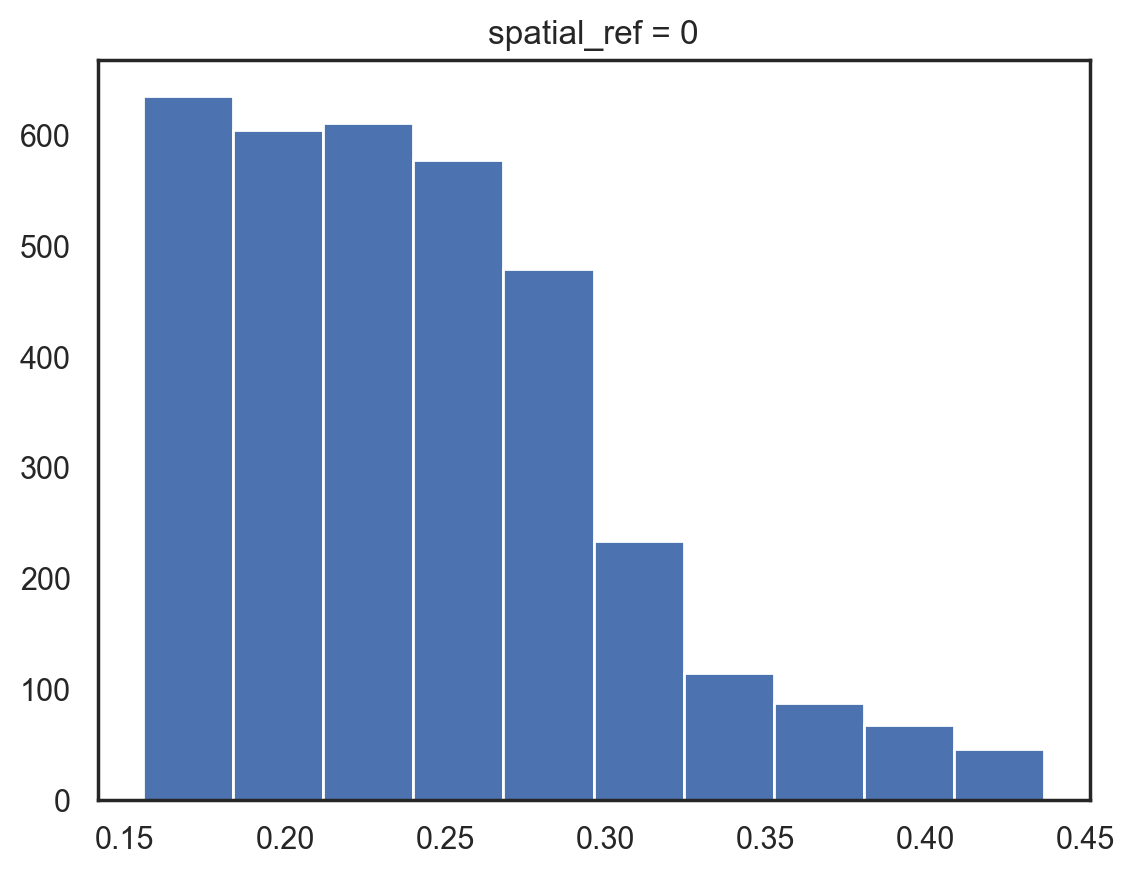

In [14]:
significant_corr = corr[0].where(corr[1] < 0.1)
significant_corr.where(significant_corr >= 0).plot.hist(bins=10);

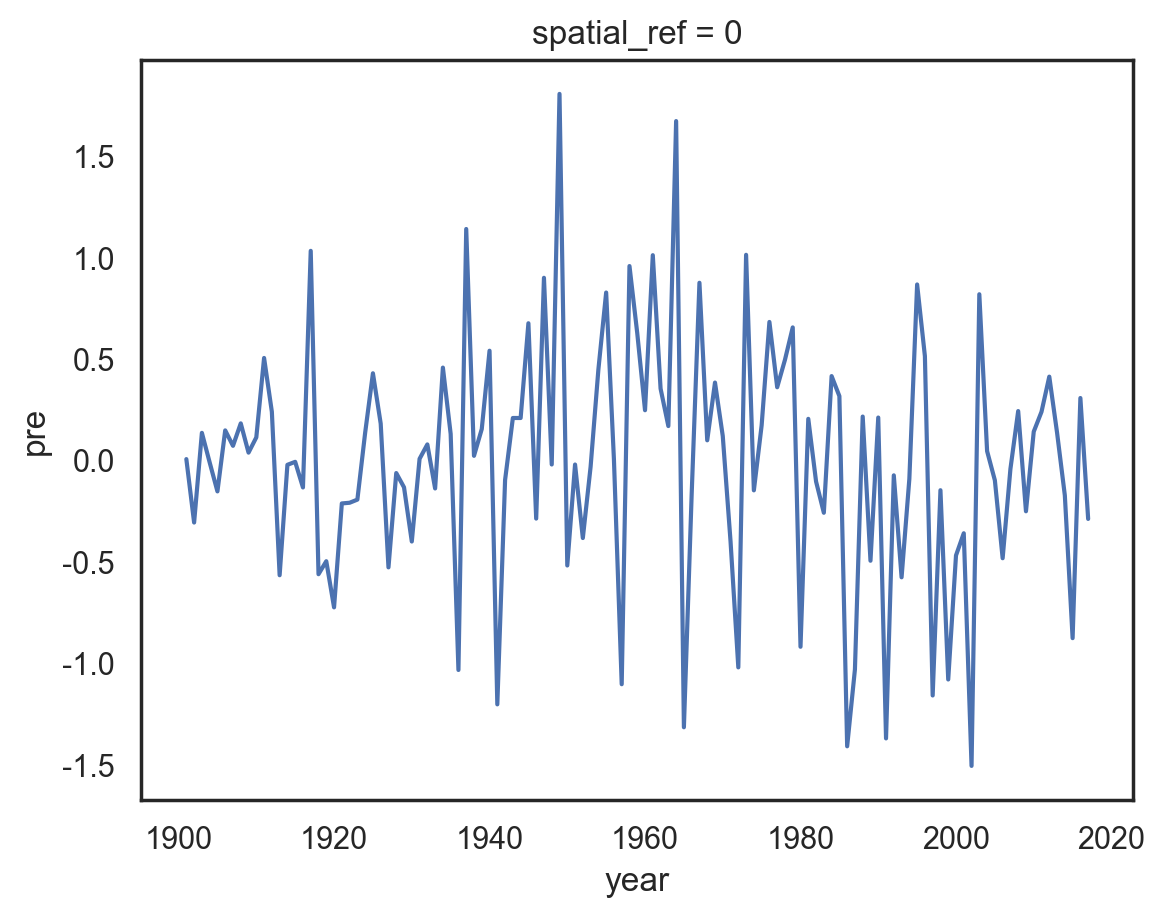

In [15]:
mins = region.bounds.min()
maxs = region.bounds.max()

sel_dict = {
    "y": slice(maxs.maxy, mins.miny),
    "x": slice(mins.minx, maxs.maxx),
}
series = summer_precip_z.sel(sel_dict).mean(dim=["x", "y"])
series.plot()
series.to_series().to_csv("data/summer_precip_z.csv")